In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf

energy_index = yf.download(
    '^GSPE',
    start = '1990-01-01',
    progress = False,
    interval = '1d',
    multi_level_index=False,
    auto_adjust=False
)

In [2]:
energy = energy_index['Close'].resample('W-FRI').last()

In [116]:
energy

Date
1993-05-07    100.879997
1993-05-14    101.010002
1993-05-21    101.379997
1993-05-28    102.790001
1993-06-04    103.500000
                 ...    
2025-12-26    679.340027
2026-01-02    701.679993
2026-01-09    716.630005
2026-01-16    733.950012
2026-01-23    732.700012
Freq: W-FRI, Name: Close, Length: 1708, dtype: float64

In [4]:
product_supplied = pd.read_excel(
    '../data/commodity/EIA Weekly Supply Estimation.xlsx',
    sheet_name = 'Product Supplied',
    header = 0,
    index_col=1
).iloc[1:]
inventory = pd.read_excel(
    '../data/commodity/EIA Weekly Supply Estimation.xlsx',
    sheet_name = 'Inventory',
    header = 0,
    index_col=1
).iloc[1:]
production = pd.read_excel(
    '../data/commodity/EIA Weekly Supply Estimation.xlsx',
    sheet_name = 'Production',
    header = 0,
    index_col=1
).iloc[1:]

<Axes: >

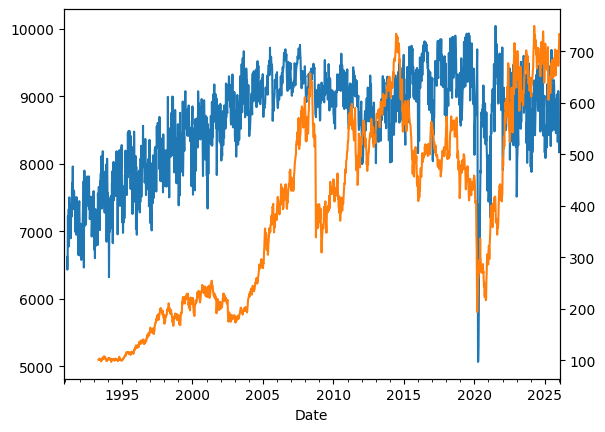

In [9]:
product_supplied['Weekly U.S. Product Supplied of Finished Motor Gasoline  (Thousand Barrels per Day)'].resample('W-FRI').last().plot()
energy.plot(secondary_y=True)

<Axes: >

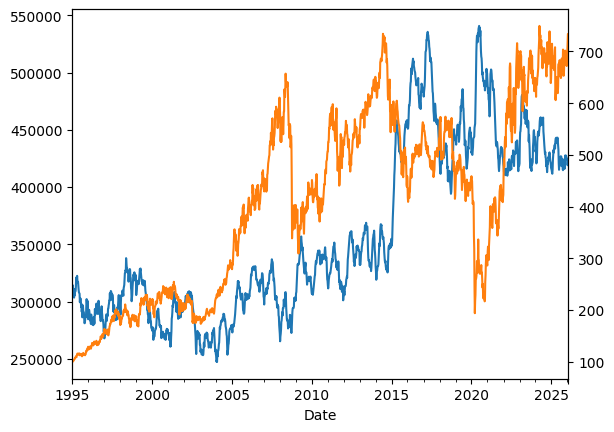

In [10]:
inventory['Stocks of Crude Oil'].resample('W-FRI').last().loc['1995':].plot()
energy.loc['1995':].plot(secondary_y=True)

<Axes: >

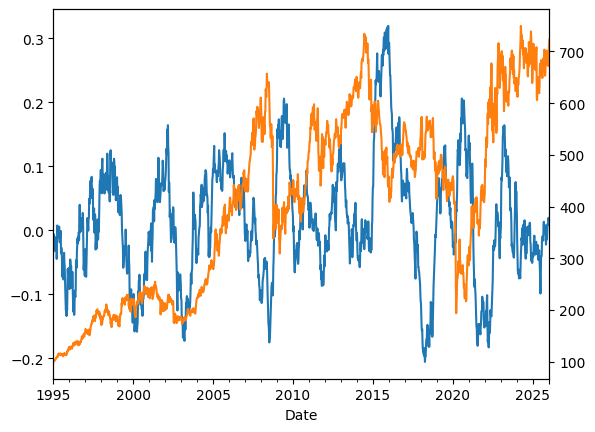

In [48]:
inventory['Stocks of Crude Oil'].resample('W-FRI').last().pct_change(52).loc['1995':].plot()
energy.loc['1995':].plot(secondary_y=True)

### Crack Spread

In [15]:
from tvDatafeed import TvDatafeed, Interval

tv = TvDatafeed()

crack_spread_futures = tv.get_hist(
    symbol = 'ARE1!',
    exchange = 'NYMEX',
    interval = Interval.in_daily,
    n_bars = 13000,
)

#### Refining Margin

<Axes: >

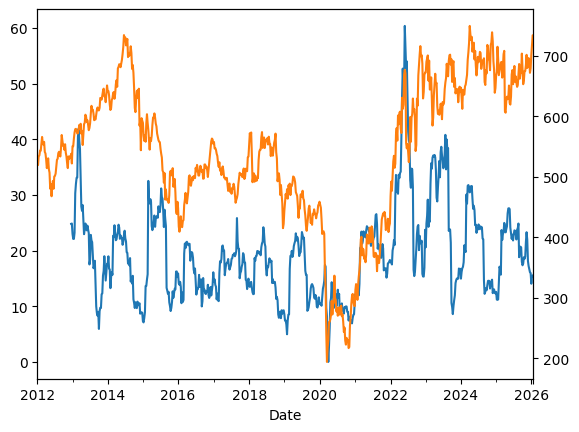

In [22]:
crack_spread_futures['close'].resample('W-FRI').last().plot()
energy_index.loc['2012':, 'Close'].resample('W-FRI').last().plot(secondary_y = True)

#### Operating Rate

In [23]:
operating_rate = pd.read_excel(
    '../data/commodity/EIA Weekly Supply Estimation.xlsx',
    sheet_name = 'Operate',
    header = 0,
    index_col=1
).iloc[1:]

<Axes: >

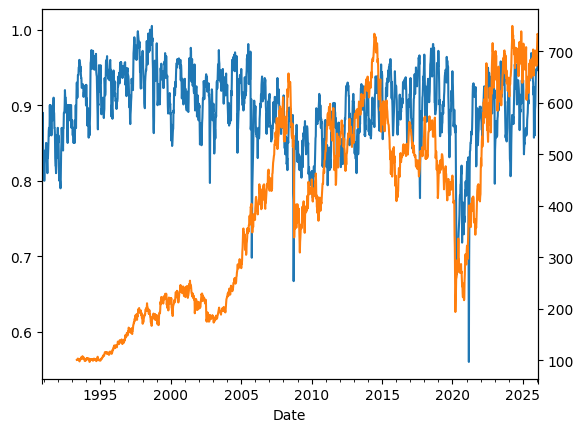

In [27]:
operating_rate['Refinery Operable Capacity'].plot()
energy_index.loc['1990':, 'Close'].resample('W-FRI').last().plot(secondary_y = True)

In [29]:
# Operating Rate x refining margin

operating_rate_resample = operating_rate['Refinery Operable Capacity'].resample('W-FRI').last()
refining_margin_resample = crack_spread_futures['close'].resample('W-FRI').last()

<Axes: >

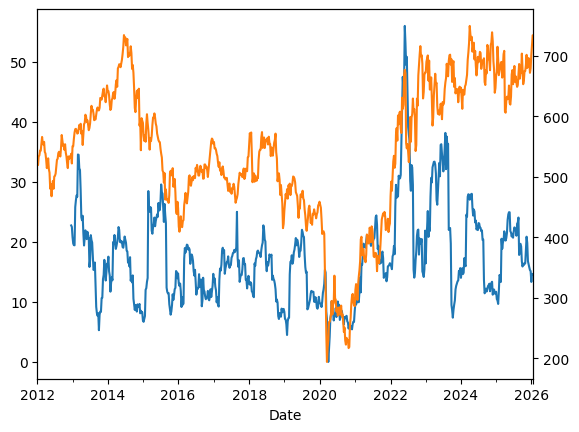

In [35]:
(operating_rate_resample * refining_margin_resample).dropna().plot()
energy_index.loc['2012':, 'Close'].resample('W-FRI').last().plot(secondary_y = True)

#### Inventories

In [36]:
inventory_resample = inventory['Stocks of Crude Oil'].resample('W-FRI').last()

<Axes: >

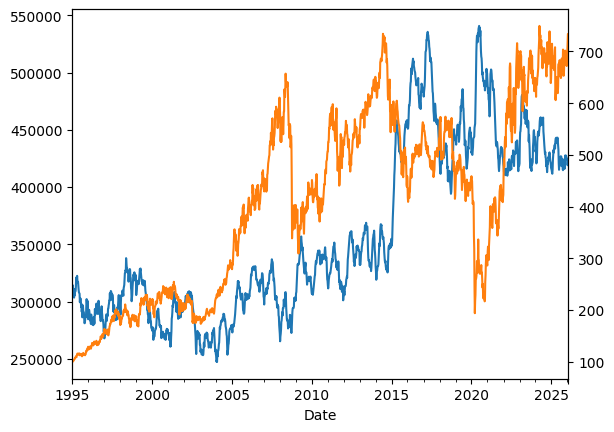

In [37]:
inventory_resample.loc['1995':].plot()
energy.loc['1995':].plot(secondary_y=True)

<Axes: >

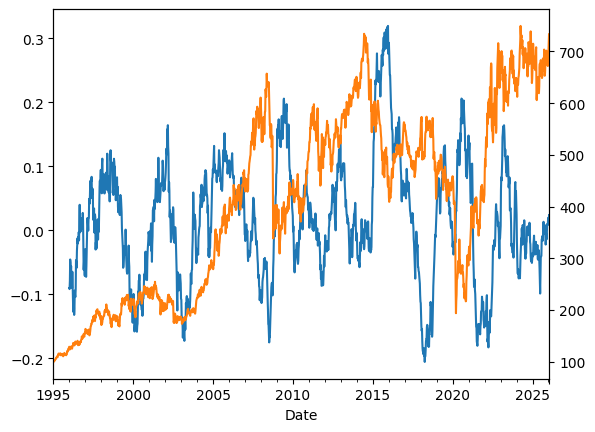

In [39]:
inventory_resample.loc['1995':].pct_change(52).plot()
energy.loc['1995':].plot(secondary_y=True)

#### Product supplied

- demand proxy

<Axes: >

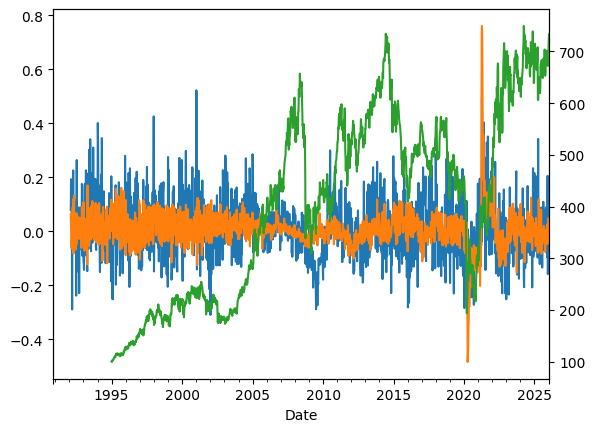

In [45]:
product_supplied['Weekly U.S. Product Supplied of Distillate Fuel Oil  (Thousand Barrels per Day)'].pct_change(52).plot()
product_supplied['Weekly U.S. Product Supplied of Finished Motor Gasoline  (Thousand Barrels per Day)'].pct_change(52).plot()
energy.loc['1995':].plot(secondary_y=True)

In [46]:
prod_feul_oil = product_supplied['Weekly U.S. Product Supplied of Distillate Fuel Oil  (Thousand Barrels per Day)'].resample('W-FRI').last()
prod_motor_gasoline = product_supplied['Weekly U.S. Product Supplied of Finished Motor Gasoline  (Thousand Barrels per Day)'].resample('W-FRI').last()

<Axes: >

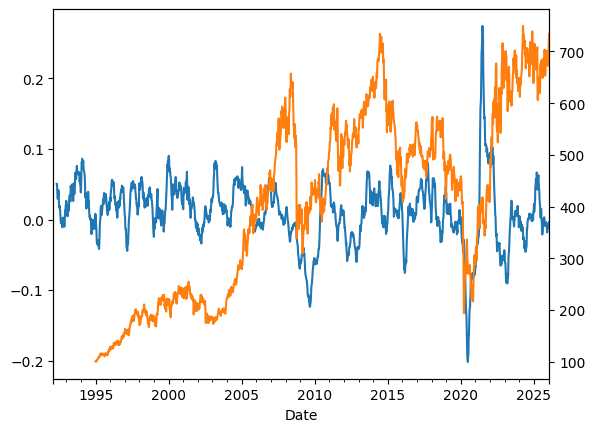

In [55]:
(prod_feul_oil.pct_change(52) * 0.6 + prod_motor_gasoline.pct_change(52) * 0.4).dropna().rolling(13).mean().plot()
energy.loc['1995':].plot(secondary_y=True)

In [58]:
prod_comp = (prod_feul_oil.pct_change(52) * 0.6 + prod_motor_gasoline.pct_change(52) * 0.4).rolling(13).mean().dropna()

<Axes: >

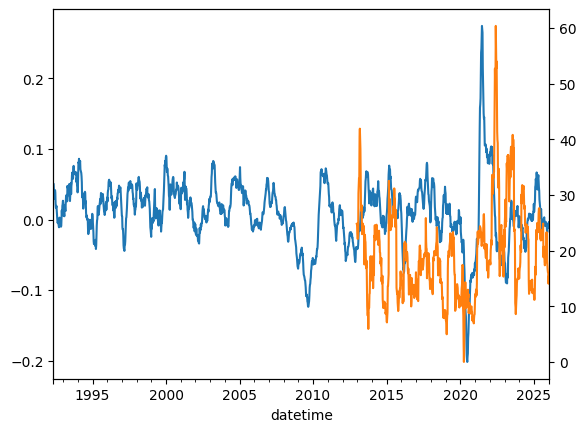

In [63]:
prod_comp.plot()
refining_margin_resample.plot(secondary_y = True)

### Crack Spread Futures Proxy

- `NYMEX:HO1!` : NY Harbor ULSD Futures
- `NYMEX:RB1!` : RBOB Gasoline Futures
- `NYMEX:CL1!` : Light Crude Oil Futures

In [64]:
harbor_futures = tv.get_hist(
    symbol = 'HO1!',
    exchange = 'NYMEX',
    interval = Interval.in_daily,
    n_bars = 13000,
)
harbor_futures.index = pd.to_datetime(harbor_futures.index.strftime('%Y-%m-%d'))

gasoline_futures = tv.get_hist(
    symbol = 'RB1!',
    exchange = 'NYMEX',
    interval = Interval.in_daily,
    n_bars = 13000,
)
gasoline_futures.index = pd.to_datetime(gasoline_futures.index.strftime('%Y-%m-%d'))

oil_futures = tv.get_hist(
    symbol = 'CL1!',
    exchange = 'NYMEX',
    interval = Interval.in_daily,
    n_bars = 13000,
)
oil_futures.index = pd.to_datetime(oil_futures.index.strftime('%Y-%m-%d'))

#### Unit Unity

$$ $/\text{Gallon} \times 42 = $/\text{Barrel}$$

- Harbor, Gasoline uses dollar/Gallon, WTI uses dollar/Barrel

In [72]:
harbor_crack = (harbor_futures['close'].resample('W-FRI').last() * 42 - oil_futures['close'].resample('W-FRI').last()).dropna()

In [73]:
gasoline_crack = (gasoline_futures['close'].resample('W-FRI').last() * 42 - oil_futures['close'].resample('W-FRI').last()).dropna()

### Oil Futures Curve

In [74]:
oil2_futures = tv.get_hist(
    symbol = 'CL2!',
    exchange = 'NYMEX',
    interval = Interval.in_daily,
    n_bars = 13000,
)
oil2_futures.index = pd.to_datetime(oil2_futures.index.strftime('%Y-%m-%d'))

In [118]:
(oil2_futures['close'] - oil_futures['close']).resample('W-FRI').last()

datetime
1983-04-01   -0.03
1983-04-08   -0.08
1983-04-15   -0.08
1983-04-22   -0.03
1983-04-29   -0.04
              ... 
2025-12-26   -0.18
2026-01-02   -0.20
2026-01-09   -0.18
2026-01-16   -0.14
2026-01-23   -0.25
Freq: W-FRI, Name: close, Length: 2235, dtype: float64

<Axes: >

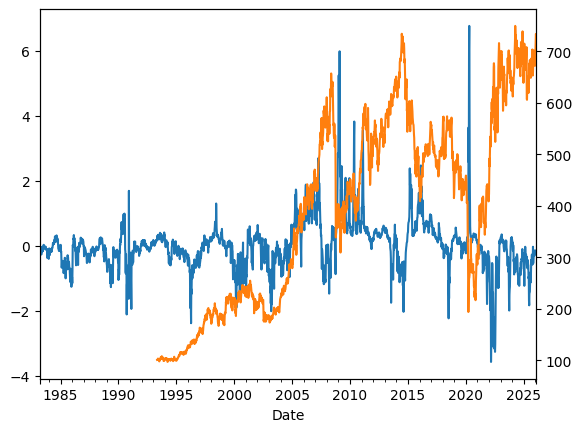

In [88]:
import matplotlib.pyplot as plt

(oil2_futures['close'] - oil_futures['close']).resample('W-FRI').last().plot()
energy.resample('W-FRI').last().plot(secondary_y=True)

In [100]:
margin_resample = (harbor_crack * 0.6 + gasoline_crack * 0.4)

In [102]:
margin_resample.dropna()

datetime
1985-03-29     4.53216
1985-04-05     4.72940
1985-04-12     3.97920
1985-04-19     4.41920
1985-04-26     5.12240
                ...   
2025-12-26    25.03820
2026-01-02    24.51028
2026-01-09    24.59608
2026-01-16    27.13632
2026-01-23    28.76608
Freq: W-FRI, Name: close, Length: 2131, dtype: float64

<Axes: >

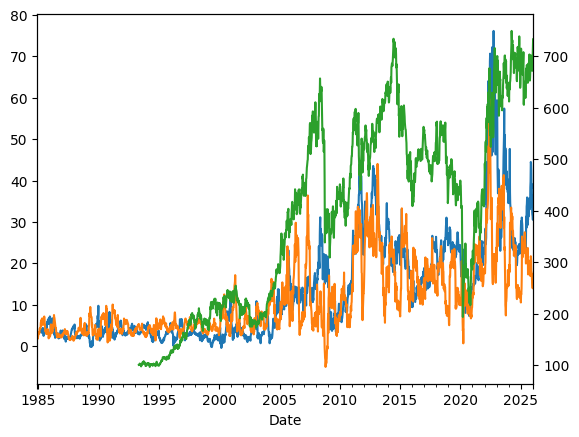

In [90]:
harbor_crack.plot()
gasoline_crack.plot()
energy.resample('W-FRI').last().plot(secondary_y=True)

In [106]:
gasoline_crack

datetime
1984-12-07     2.3600
1984-12-14     2.0100
1984-12-21     1.8290
1984-12-28     2.1920
1985-01-04     2.6240
               ...   
2025-12-26    14.9708
2026-01-02    14.0044
2026-01-09    15.6652
2026-01-16    16.8396
2026-01-23    17.4538
Freq: W-FRI, Name: close, Length: 2147, dtype: float64

In [103]:
inventory_resample.ffill()

Release Date
1982-08-27    338764
1982-09-03    336138
1982-09-10    336138
1982-09-17    336138
1982-09-24    336138
               ...  
2025-12-19    424417
2025-12-26    424822
2026-01-02    422888
2026-01-09    419056
2026-01-16    422447
Freq: W-FRI, Name: Stocks of Crude Oil, Length: 2265, dtype: int64

<Axes: >

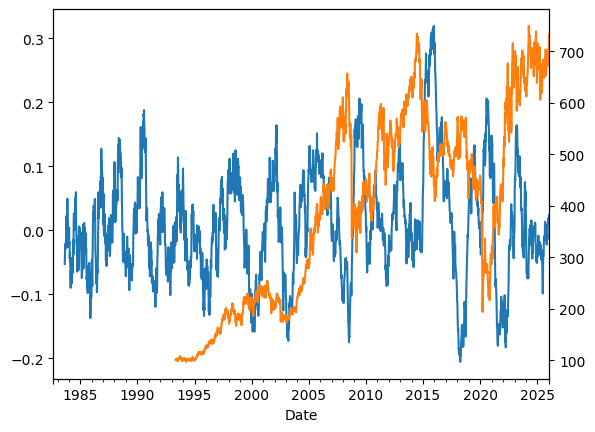

In [104]:
inventory_resample.ffill().pct_change(52).plot()
energy.resample('W-FRI').last().plot(secondary_y=True)

<Axes: >

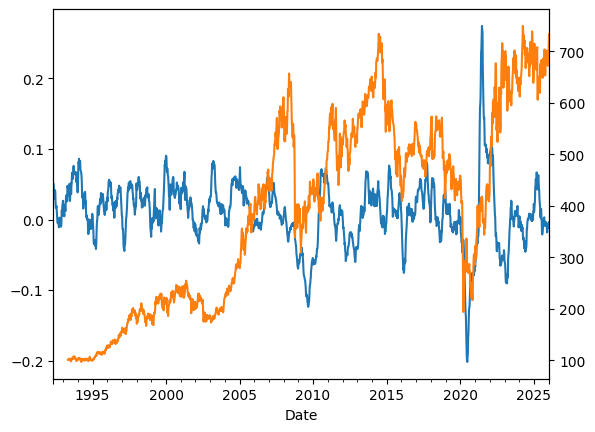

In [97]:
prod_comp.plot()
energy.resample('W-FRI').last().plot(secondary_y=True)